# CNN

#### Index<a name="index"></a>
1. [Import packages](#imports)
2. [Load data](#loadData)
3. [Classification](#classification)
    1. [Uniform distribution for non-clusters](#uni)
    2. [Functional distribution for non-clusters](#func)

## 1. Import packages<a name="imports"></a>

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Aestetic settings

In [3]:
%matplotlib inline

sns.set(font_scale=1.3, style="ticks")

## 2. Load data<a name="loadData"></a>

In [3]:
number_clusters = 1229

In [65]:
# train positive samples
true_clusters_2d_hist_file = f'/content/drive/MyDrive/Random-forest-open-cluster-master/data/true_clusters_2d_hist_{number_clusters}.npy'
true_clusters_2d_hist = np.load(true_clusters_2d_hist_file, allow_pickle=True)
   
# validation nagative samples (y = 0) - real samples from DBSCAN
val_clusters_2d_hist_file = f'/content/drive/MyDrive/Random-forest-open-cluster-master/data/matrix_false_nonclusters.npy'
val_clusters_2d_hist = np.load(val_clusters_2d_hist_file, allow_pickle=True)

x_val = val_clusters_2d_hist.reshape(-1,20,20,1)
y_val = np.zeros_like(val_clusters_2d_hist[:, 0])

In [36]:
print(np.shape(true_clusters_2d_hist))
print(np.shape(val_clusters_2d_hist))

(1229, 400)
(32, 400)


## 3. Classification<a name="classification"></a>

In [6]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see:
                  http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm = cm, 
                           normalize = True, # show proportions
                          target_names = y_labels_vals, # list of classes names
                          title = best_estimator_name) # title of graph
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.8f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Training<a name="func"></a>

In [70]:
non_clusters_2d_hist_file = f'/content/drive/MyDrive/Random-forest-open-cluster-master/data/non_clusters_2d_hist.npy'
non_clusters_2d_hist = np.load(non_clusters_2d_hist_file, allow_pickle=True)

all_clusters = np.concatenate((true_clusters_2d_hist, 
                               non_clusters_2d_hist))
true_labels = np.concatenate((np.ones_like(true_clusters_2d_hist[:, 0]), 
                              np.zeros_like(non_clusters_2d_hist[:, 0])))

x_train, x_test, y_train, y_test = train_test_split(all_clusters, true_labels, test_size=0.3, random_state=2)
x_train = x_train.reshape(-1,20,20,1)
x_test = x_test.reshape(-1,20,20,1)

print(np.shape(all_clusters))
print(len(non_clusters_2d_hist))
print(np.shape(x_train))

(2529, 400)
1300
(1770, 20, 20, 1)


In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(20,20,1)))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 18, 18, 64)        640       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 19,617
Trainable params: 19,617
Non-trainable params: 0
_________________________________________________

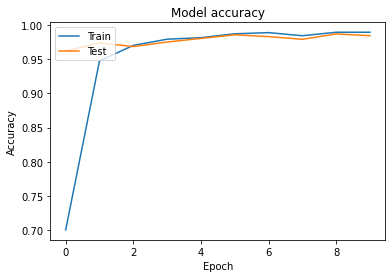

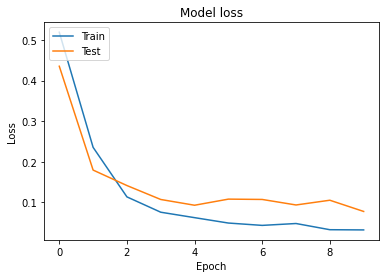

In [61]:
#accuracy & loss curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Test set

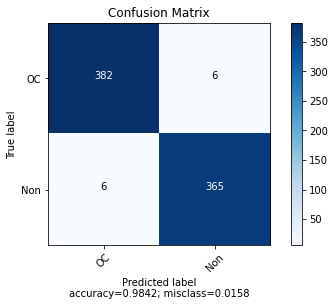

In [62]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['OC','Non'], title='Confusion Matrix', cmap=None, normalize= False)
                                
#plot_confusion_matrix(y_test, y_pred, 'Confusion matrix\nmax_depth=2', (0,1),normalize = False)

#### Validation set

In [69]:
y_pred_val = model.predict(x_val)
y_pred_val = (y_pred_val > 0.5).astype(int)
y_pred_val

#print("Accuracy: ", accuracy_score(y_val, y_pred_val))
#plot_confusion_matrix(y_val, y_pred_val, 'Confusion matrix\nmax_depth=2', [1, 0], normalize=False)

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

Go to [Index](#index)